## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [1]:
import pandas as pd
url = "https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1"
df = pd.read_csv(url)
df = df.dropna()
df['sex'] = df['sex'].astype('category')
df['cp'] = df['cp'].astype('category')
df['restecg'] = df['restecg'].astype('category')
df['diagnosis'] = df['diagnosis'].astype('category')
df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


In [2]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [3]:
X = df[["age", "chol"]]
y = df["diagnosis"]

ct = ColumnTransformer(
    transformers = [
      ("dummify", OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'),
        make_column_selector(dtype_include = ['category']))    ],
    remainder = "passthrough"
)

log_pipe = Pipeline([
    ("preprocessing", ct),
    ("log", LogisticRegression(max_iter = 1000))
])

log_pipe.fit(X, y)

coefs = log_pipe.named_steps["log"].coef_[0]
intercept = log_pipe.named_steps["log"].intercept_[0]

age_coef = coefs[0]
chol_coef = coefs[1]

coef_df = pd.DataFrame({
    "Predictor": [['age', 'chol']],
    "Coefficient": [coefs],
    "Intercept": [intercept]
})
coef_df

,Predictor,Coefficient,Intercept
0,"[age, chol]","[0.04686330613037214, 0.0018012385190290258]",-3.240112


In [4]:
import math

chol_55 = (-intercept - (age_coef * 55))/chol_coef
chol_55

np.float64(367.8748897985677)

In [5]:
z = math.log10((0.9)/(1-0.9))

high_chol = (z - intercept - (age_coef * 55))/chol_coef
high_chol

np.float64(897.6451003277754)

For a 55 year old, they would have to have a cholesterol of 367.87 in order for a doctor to predict heart disease is present.

To estimate a 90% chance that heart disease is present, they would have to have a cholesterol of 897.65.

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = df[["age", "chol"]]
y = df["diagnosis"]

ct = ColumnTransformer(
    transformers = [
      ("dummify", OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'),
        make_column_selector(dtype_include = ['category']))    ],
    remainder = "passthrough"
)

lda_pipe = Pipeline([
    ("preprocessing", ct),
    ("lda", LinearDiscriminantAnalysis())
])

lda_pipe.fit(X, y)

coefs = lda_pipe.named_steps["lda"].coef_[0]
intercept = lda_pipe.named_steps["lda"].intercept_[0]

age_coef = coefs[0]
chol_coef = coefs[1]

lda_coef_df = pd.DataFrame({
    "Predictor": [["age", "chol"]],
    "Coefficient": [coefs],
    "Intercept": [intercept]
})
lda_coef_df

,Predictor,Coefficient,Intercept
0,"[age, chol]","[0.04655743553694484, 0.0017896671039291314]",-3.219678


In [7]:
chol_55 = (-intercept - (age_coef * 55))/chol_coef
chol_55

np.float64(368.235357529938)

For a 55 year old, they would have to have a cholesterol of 368 in order for a doctor to predict heart disease is present.

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [8]:
from sklearn.svm import SVC

X = df[["age", "chol"]]
y = df["diagnosis"]

ct = ColumnTransformer(
    transformers = [
      ("dummify", OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'),
        make_column_selector(dtype_include = ['category']))    ],
    remainder = "passthrough"
)

svc_pipe = Pipeline([
    ("preprocessing", ct),
    ("svc", SVC(kernel = "linear"))
])

params = {"svc__C": np.logspace(-3, 3, 10)}

svc_roc_auc = GridSearchCV(estimator = svc_pipe, param_grid = params, cv = 5, scoring = "roc_auc")

svc_roc_auc.fit(X, y)
svc_pipe.fit(X, y)

age_coef = coefs[0]
chol_coef = coefs[1]

coef_names = svc_pipe.named_steps["preprocessing"].get_feature_names_out()
coefs = svc_pipe.named_steps["svc"].coef_[0]
intercept = svc_pipe.named_steps["svc"].intercept_[0]

svc_coef_df = pd.DataFrame({
    "Predictor": [coef_names],
    "Coefficient": [coefs],
    "Intercept": [intercept]
})
svc_coef_df

,Predictor,Coefficient,Intercept
0,"[remainder__age, remainder__chol]","[0.06439772419707879, 0.0036589616029232275]",-4.686034


In [9]:
chol_55 = (-intercept - (age_coef * 55))/chol_coef
chol_55

np.float64(1187.581252408962)

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

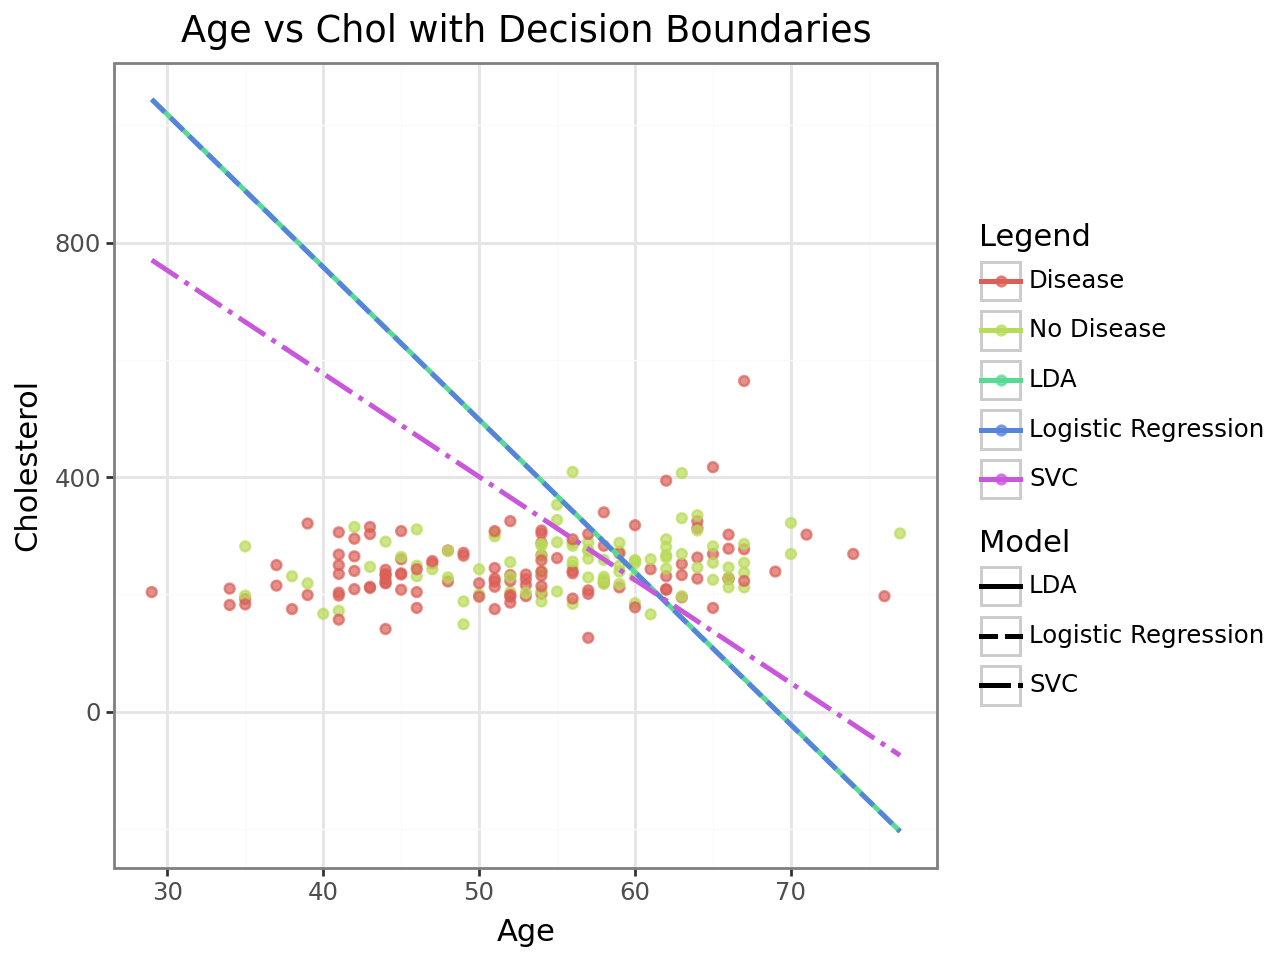

In [10]:
from plotnine import *

def get_line_df(model, label, color):
    intercept = model.intercept_[0]
    age_coef, chol_coef = model.coef_[0]
    age_vals = np.linspace(df["age"].min(), df["age"].max(), 100)
    chol_vals = -(intercept + age_coef * age_vals) / chol_coef
    return pd.DataFrame({"age": age_vals, "chol": chol_vals, "Model": label, "Color": color})

log_model = log_pipe.named_steps["log"]
lda_model = lda_pipe.named_steps["lda"]
svc_model = svc_pipe.named_steps["svc"]

lines = pd.concat([
    get_line_df(log_model, "Logistic Regression", "black"),
    get_line_df(lda_model, "LDA", "blue"),
    get_line_df(svc_model, "SVC", "red")
])

(
    ggplot(df, aes(
        x = "age",
        y = "chol"))
    + geom_point(aes(color="factor(diagnosis)"), alpha = 0.7)
    + geom_line(
        data = lines,
        mapping = aes(
            x = "age",
            y = "chol",
            linetype = "Model",
            color = "Model"),
        size = 1)
    + labs(
        title = "Age vs Chol with Decision Boundaries",
        x = "Age",
        y = "Cholesterol",
        color = "Legend",
        linetype = "Model")
    + theme_bw()
)
